In [1]:
import keras.backend as K
from perso import *
import sys
import pickle
sys.path.append('../MTCNN/keras-mtcnn-master/')
import tools_matrix as tools
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from MTCNN import create_Kao_Onet, create_Kao_Rnet, create_Kao_Pnet

Using TensorFlow backend.


In [2]:
def detectFace(img, threshold, Pnet, Rnet, Onet):

    caffe_img = (img.copy() - 127.5) / 127.5
    origin_h, origin_w, ch = caffe_img.shape
    scales = tools.calculateScales(img)
    out = []
    t0 = time.time()
    # del scales[:4]

    for scale in scales:
        hs = int(origin_h * scale)
        ws = int(origin_w * scale)
        scale_img = cv2.resize(caffe_img, (ws, hs))
        input = scale_img.reshape(1, *scale_img.shape)
        ouput = Pnet.predict(input)  # .transpose(0,2,1,3) should add, but seems after process is wrong then.
        out.append(ouput)
    image_num = len(scales)
    rectangles = []
    for i in range(image_num):
        cls_prob = out[i][0][0][:, :,
                   1]  # i = #scale, first 0 select cls score, second 0 = batchnum, alway=0. 1 one hot repr
        roi = out[i][1][0]
        out_h, out_w = cls_prob.shape
        out_side = max(out_h, out_w)
        # print('calculating img scale #:', i)
        cls_prob = np.swapaxes(cls_prob, 0, 1)
        roi = np.swapaxes(roi, 0, 2)
        rectangle = tools.detect_face_12net(cls_prob, roi, out_side, 1 / scales[i], origin_w, origin_h, threshold[0])
        rectangles.extend(rectangle)
    rectangles = tools.NMS(rectangles, 0.7, 'iou')

    t1 = time.time()
    print ('time for 12 net is: ', t1-t0, len(rectangles))

    if len(rectangles) == 0:
        return rectangles

    crop_number = 0
    out = []
    predict_24_batch = []
    for rectangle in rectangles:
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (24, 24))
        predict_24_batch.append(scale_img)
        crop_number += 1

    predict_24_batch = np.array(predict_24_batch)

    out = Rnet.predict(predict_24_batch)

    cls_prob = out[0]  # first 0 is to select cls, second batch number, always =0
    cls_prob = np.array(cls_prob)  # convert to numpy
    roi_prob = out[1]  # first 0 is to select roi, second batch number, always =0
    roi_prob = np.array(roi_prob)
    rectangles = tools.filter_face_24net(cls_prob, roi_prob, rectangles, origin_w, origin_h, threshold[1])
    t2 = time.time()
    print ('time for 24 net is: ', t2-t1, len(rectangles))


    if len(rectangles) == 0:
        return rectangles


    crop_number = 0
    predict_batch = []
    for rectangle in rectangles:
        # print('calculating net 48 crop_number:', crop_number)
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (48, 48))
        predict_batch.append(scale_img)
        crop_number += 1

    predict_batch = np.array(predict_batch)

    output = Onet.predict(predict_batch)
    cls_prob = output[0]
    roi_prob = output[1]
    pts_prob = output[2]  # index
    # rectangles = tools.filter_face_48net_newdef(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h,
    #                                             threshold[2])
    rectangles = tools.filter_face_48net(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h, threshold[2])
    t3 = time.time()
    print ('time for 48 net is: ', t3-t2, len(rectangles))

    return rectangles

def get_face(img, Pnet, Rnet, Onet):
    threshold = [0.6,0.6,0.7]
    # ret, img = cap.read()
    img = cv2.imread(img)
    rectangles = detectFace(img, threshold, Pnet, Rnet, Onet)
    draw = np.zeros(img.shape)

    for rectangle in rectangles:
        if rectangle is not None:
            print(np.round(np.array(rectangle)))
            W = -int(rectangle[0]) + int(rectangle[2])
            H = -int(rectangle[1]) + int(rectangle[3])
            paddingH = 0.01 * W
            paddingW = 0.02 * H
            for row in range(draw.shape[0]):
                for px in range(draw.shape[1]):
                    if row > int(rectangle[1]+paddingH) and row < int(rectangle[3]-paddingH):
                        if px > int(rectangle[0]-paddingW) and px < int(rectangle[2]+paddingW):
                            draw[row][px] = img[row][px]
    return draw.astype('uint8')[:,:,[2,1,0]]

In [3]:
images_path = 'data/640x640/test'
pose_path = 'data/640x640/cropped/test/pose'
face_path = 'data/640x640/cropped/test/face'
ext = '.png'
nbr_imgs = 5469
K.clear_session()
Pnet = create_Kao_Pnet('../MTCNN/keras-mtcnn-master/12net.h5')
Rnet = create_Kao_Rnet('../MTCNN/keras-mtcnn-master/24net.h5')
Onet = create_Kao_Onet('../MTCNN/keras-mtcnn-master/48net.h5')
    
for f in range(nbr_imgs):
    face = get_face(images_path+'/{}{}'.format(f, ext), Pnet, Rnet, Onet)
    try: pose = cv2.imread(pose_path+'/{}.png'.format(f))[:,:,::-1]
    except: continue
    for row in range(face.shape[0]):
        for px in range(face.shape[1]):
            if face[row][px].all() != np.zeros(3).all():
                pose[row][px] = face[row][px]
    image = Image.fromarray(pose.astype('uint8'), 'RGB')
    image.save(face_path+'/{}.png'.format(f))

time for 12 net is:  2.3581748008728027 78
time for 24 net is:  0.19768428802490234 1
time for 48 net is:  0.05503058433532715 0
time for 12 net is:  0.03996086120605469 75
time for 24 net is:  0.011086702346801758 3
time for 48 net is:  0.010813236236572266 1
[242. 117. 387. 309.   1. 294. 192. 363. 200. 331. 243. 282. 259. 350.
 266.]
time for 12 net is:  0.03888416290283203 81
time for 24 net is:  0.011768817901611328 7
time for 48 net is:  0.011813163757324219 2
[406. 202. 425. 226.   1. 418. 213. 423. 212. 424. 216. 418. 220. 423.
 219.]
[255. 132. 379. 287.   1. 307. 187. 361. 197. 341. 227. 299. 244. 349.
 253.]
time for 12 net is:  0.042281389236450195 125
time for 24 net is:  0.014043092727661133 1
time for 48 net is:  0.0023212432861328125 1
[261. 119. 396. 296.   1. 301. 192. 367. 197. 329. 239. 299. 253. 361.
 257.]
time for 12 net is:  0.037859439849853516 90
time for 24 net is:  0.012354612350463867 1
time for 48 net is:  0.002379894256591797 1
[269. 134. 331. 219.   1. 2

AttributeError: 'NoneType' object has no attribute 'copy'

In [5]:
person_path = 'data/640x640/cropped/test/person'
for f in range(nbr_imgs):
    try: pose = cv2.imread(pose_path+'/{}.png'.format(f))[:,:,::-1]
    except: continue
    full = cv2.imread(images_path+'/{}.png'.format(f))[:,:,::-1]
    person = np.zeros(full.shape)
    person[pose != np.repeat(0,3)] = full[pose != np.repeat(0,3)]
    print(f)
    image = Image.fromarray(person.astype('uint8'), 'RGB')
    image.save(person_path+'/{}.png'.format(f))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [17]:
person = np.zeros(full.shape)

In [18]:
person[pose != np.repeat(0,3)] = full[pose != np.repeat(0,3)]

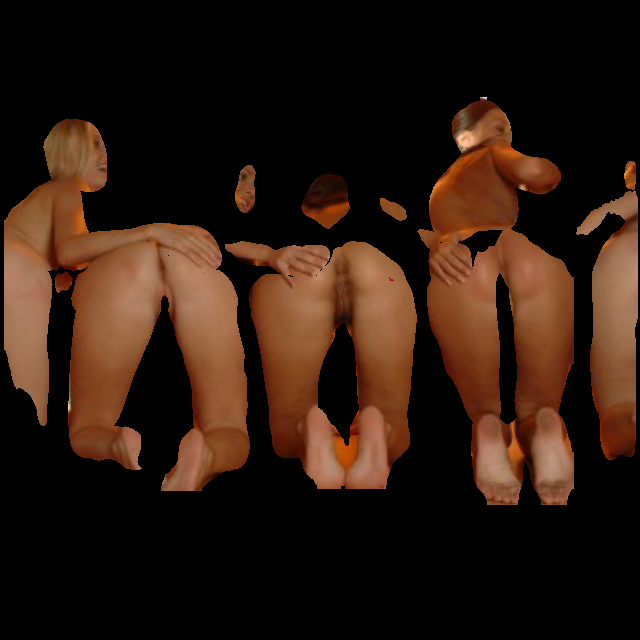

In [19]:
Image.fromarray(person.astype('uint8'), 'RGB')